In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
data = np.genfromtxt('cs438Project/winequality.csv', delimiter=',', names=True)
data

array([(7.4, 0.7 , 0.  , 1.9, 0.076, 11.,  34., 0.9978 , 3.51, 0.56,  9.4, 1., 5.),
       (7.8, 0.88, 0.  , 2.6, 0.098, 25.,  67., 0.9968 , 3.2 , 0.68,  9.8, 1., 5.),
       (7.8, 0.76, 0.04, 2.3, 0.092, 15.,  54., 0.997  , 3.26, 0.65,  9.8, 1., 5.),
       ...,
       (6.5, 0.24, 0.19, 1.2, 0.041, 30., 111., 0.99254, 2.99, 0.46,  9.4, 0., 6.),
       (5.5, 0.29, 0.3 , 1.1, 0.022, 20., 110., 0.98869, 3.34, 0.38, 12.8, 0., 7.),
       (6. , 0.21, 0.38, 0.8, 0.02 , 22.,  98., 0.98941, 3.26, 0.32, 11.8, 0., 6.)],
      dtype=[('fixed_acidity', '<f8'), ('volatile_acidity', '<f8'), ('citric_acid', '<f8'), ('residual_sugar', '<f8'), ('chlorides', '<f8'), ('free_sulfur_dioxide', '<f8'), ('total_sulfur_dioxide', '<f8'), ('density', '<f8'), ('pH', '<f8'), ('sulphates', '<f8'), ('alcohol', '<f8'), ('color', '<f8'), ('quality', '<f8')])

(array([  30.,  216., 2138., 2836., 1079.,  198.]),
 array([3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 6 artists>)

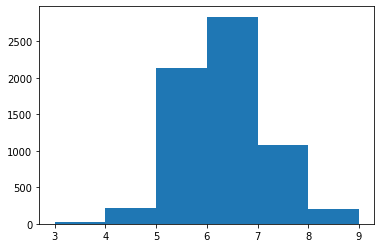

In [4]:
plt.hist(data['quality'], bins=6)

In [5]:
arr = data.view((float, len(data.dtype.names)))

X = arr[:, :-2]
y_quality = (arr[:, -1] > 5).astype(int)
y_color = arr[:, -2]

# scale the input parameters
X = preprocessing.scale(X)

print(y_quality.mean())
print(y_color.mean())

0.6330614129598277
0.2461135908881022


In [6]:
X_tv, X_test, y_quality_tv, y_quality_test, y_color_tv, y_color_test = train_test_split(X, y_quality, y_color, test_size=0.2, random_state=0)
X_train, X_validation, y_quality_train, y_quality_validation, y_color_train, y_color_validation = train_test_split(X_tv, y_quality_tv, y_color_tv, test_size=0.2, random_state=1)

Now we try the different classifiers:
- logistic regression
- Random forest
- SVM (linear)
- SVM (gaussian)
- Neural Network

In [7]:
# logistic regression
from sklearn.linear_model import LogisticRegression

def tune_logistic(name, lambdas, y_train, y_validation, y_test, **kwargs):
    """
    Analyze different values of lambda
    """
    training_accuracies = []
    validation_accuracies = []
    test_accuracies = []
    for i, l in enumerate(lambdas):
        print(f'\r[{"#" * round(80 * i/len(lambdas)):{80}}]', end='')
        regr = LogisticRegression(C=1/l, solver='saga', penalty='l2', **kwargs)
        regr.fit(X_train, y_train)
        train_pred = regr.predict(X_train)
        training_accuracies.append(metrics.accuracy_score(y_train, train_pred))
        validation_pred = regr.predict(X_validation)
        validation_accuracies.append(metrics.accuracy_score(y_validation, validation_pred))
        test_pred = regr.predict(X_test)
        test_accuracies.append(metrics.accuracy_score(y_test, test_pred))

    plt.plot(lambdas, training_accuracies, label='Training')
    plt.plot(lambdas, validation_accuracies, label='Validation')
    plt.xlabel('lambda (higher lambda means higher regularization)')
    plt.ylabel('Accuracy')

    l = lambdas[np.argmax(validation_accuracies)]
    plt.scatter(l, test_accuracies[np.argmax(validation_accuracies)], label=f'Test accuracy: {test_accuracies[np.argmax(validation_accuracies)]:.2f}')
    plt.vlines(l, np.min(validation_accuracies + training_accuracies), np.max(validation_accuracies + training_accuracies), linestyles='dashed', label=f'Best lambda: {l:.2f}')
    plt.legend()
    plt.title(name)
    plt.show()
    return l

[################################################################################]

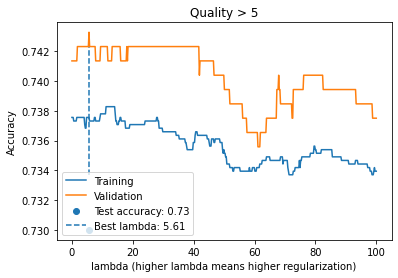

5.611316833667334

In [8]:
# quality
lambdas = np.linspace(0.0001, 100, 500)

tune_logistic("Quality > 5", lambdas, y_quality_train, y_quality_validation, y_quality_test)

[################################################################################]

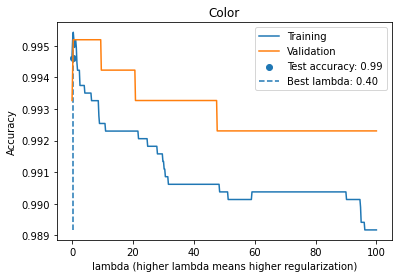

0.4009012024048096

In [9]:
lambdas = np.linspace(0.0001, 100, 500)

tune_logistic("Color", lambdas, y_color_train, y_color_validation, y_color_test, max_iter=1000)

In [10]:
# linear SVM
from sklearn.svm import SVC

def tune_linear_svm(name, C_values, y_train, y_validation, y_test, **kwargs):
    """
    Analyze different regularization values for support vector machine
    """
    training_accuracies = []
    validation_accuracies = []
    test_accuracies = []
    for i, C in enumerate(C_values):
        print(f'\r[{"#" * round(80 * i/len(C_values)):{80}}]', end='')
        regr = SVC(C=C, kernel='linear', **kwargs)
        regr.fit(X_train, y_train)
        train_pred = regr.predict(X_train)
        training_accuracies.append(metrics.accuracy_score(y_train, train_pred))
        validation_pred = regr.predict(X_validation)
        validation_accuracies.append(metrics.accuracy_score(y_validation, validation_pred))
        test_pred = regr.predict(X_test)
        test_accuracies.append(metrics.accuracy_score(y_test, test_pred))

    plt.gca().set_xscale('log')

    plt.plot(C_values, training_accuracies, label='Training')
    plt.plot(C_values, validation_accuracies, label='Validation')
    plt.xlabel('C (lower C means more regularization)')
    plt.ylabel('Accuracy')

    C = C_values[np.argmax(validation_accuracies)]
    plt.scatter(C, test_accuracies[np.argmax(validation_accuracies)], label=f'Test accuracy: {test_accuracies[np.argmax(validation_accuracies)]:.2f}')
    plt.vlines(C, np.min(validation_accuracies + training_accuracies), np.max(validation_accuracies + training_accuracies), linestyles='dashed', label=f'Best C: {C:.2f}')
    plt.legend()
    plt.title(name)
    plt.show()
    return C

[################################################################################]

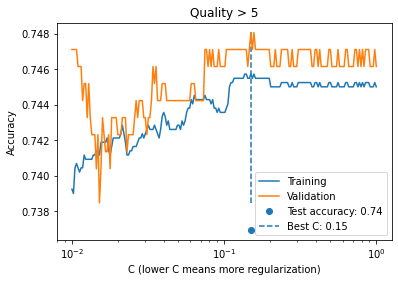

0.14992684327860456

In [11]:
c_values = np.logspace(-2, 0, 200)

tune_linear_svm('Quality > 5', c_values, y_quality_train, y_quality_validation, y_quality_test)

[################################################################################]

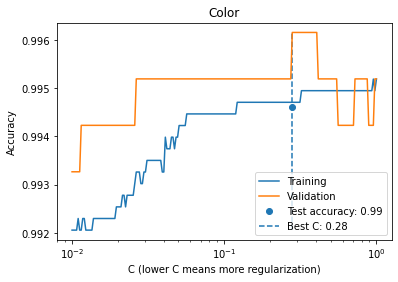

0.2800503894183631

In [12]:
c_values = np.logspace(-2, 0, 200)

tune_linear_svm('Color', c_values, y_color_train, y_color_validation, y_color_test)

In [13]:
# gaussian SVM
from sklearn.svm import SVC

def tune_gaussian_svm(name, C_values, y_train, y_validation, y_test, **kwargs):
    """
    Analyze different regularization values for support vector machine
    """
    training_accuracies = []
    validation_accuracies = []
    test_accuracies = []
    for i, C in enumerate(C_values):
        print(f'\r[{"#" * round(80 * i/len(C_values)):{80}}]', end='')
        regr = SVC(C=C, kernel='rbf', **kwargs)
        regr.fit(X_train, y_train)
        train_pred = regr.predict(X_train)
        training_accuracies.append(metrics.accuracy_score(y_train, train_pred))
        validation_pred = regr.predict(X_validation)
        validation_accuracies.append(metrics.accuracy_score(y_validation, validation_pred))
        test_pred = regr.predict(X_test)
        test_accuracies.append(metrics.accuracy_score(y_test, test_pred))

    plt.gca().set_xscale('log')

    plt.plot(C_values, training_accuracies, label='Training')
    plt.plot(C_values, validation_accuracies, label='Validation')
    plt.xlabel('C (lower C means more regularization)')
    plt.ylabel('Accuracy')

    C = C_values[np.argmax(validation_accuracies)]
    plt.scatter(C, test_accuracies[np.argmax(validation_accuracies)], label=f'Test accuracy: {test_accuracies[np.argmax(validation_accuracies)]:.2f}')
    plt.vlines(C, np.min(validation_accuracies + training_accuracies), np.max(validation_accuracies + training_accuracies), linestyles='dashed', label=f'Best C: {C:.2f}')
    plt.legend()
    plt.title(name)
    plt.show()
    return C

[##############################################################################  ]

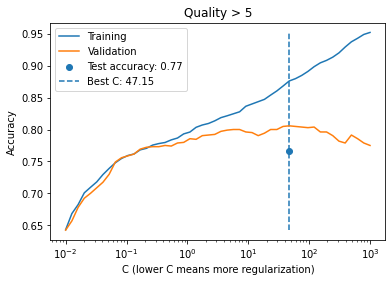

In [14]:
c_values = np.logspace(-2, 3, 50)

C_qual = tune_gaussian_svm('Quality > 5', c_values, y_quality_train, y_quality_validation, y_quality_test)

[##############################################################################  ]

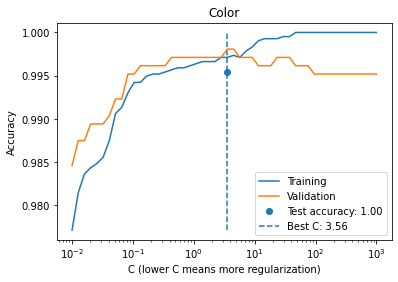

In [15]:
c_values = np.logspace(-2, 3, 50)

C_color = tune_gaussian_svm('Color', c_values, y_color_train, y_color_validation, y_color_test)

In [16]:
# now tune gamma

def tune_gaussian_svm_gamma(name, gamma_values, C, y_train, y_validation, y_test, **kwargs):
    """
    Analyze different gamma values for support vector machine
    """
    training_accuracies = []
    validation_accuracies = []
    test_accuracies = []
    lgamma = len(gamma_values)
    for i, gamma in enumerate(gamma_values):
        print(f'\r[{"#" * round(80 * i/lgamma):{80}}] {round(100 * i/lgamma):3d}%', end='')
        regr = SVC(C=C, kernel='rbf', gamma=gamma, **kwargs)
        regr.fit(X_train, y_train)
        train_pred = regr.predict(X_train)
        training_accuracies.append(metrics.accuracy_score(y_train, train_pred))
        validation_pred = regr.predict(X_validation)
        validation_accuracies.append(metrics.accuracy_score(y_validation, validation_pred))
        test_pred = regr.predict(X_test)
        test_accuracies.append(metrics.accuracy_score(y_test, test_pred))

    plt.gca().set_xscale('log')

    plt.plot(gamma_values, training_accuracies, label='Training')
    plt.plot(gamma_values, validation_accuracies, label='Validation')
    plt.xlabel('gamma')
    plt.ylabel('Accuracy')

    gamma = gamma_values[np.argmax(validation_accuracies)]
    plt.scatter(gamma, test_accuracies[np.argmax(validation_accuracies)], label=f'Test accuracy: {test_accuracies[np.argmax(validation_accuracies)]:.2f}')
    plt.vlines(gamma, np.min(validation_accuracies + training_accuracies), np.max(validation_accuracies + training_accuracies), linestyles='dashed', label=f'Best gamma: {gamma:.2f}')
    plt.legend()
    plt.title(name)
    plt.show()
    return gamma

[##############################################################################  ]  98%

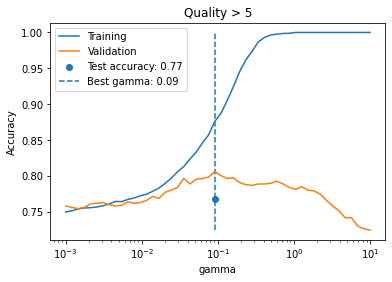

0.09102981779915217

In [17]:
gamma_values = np.logspace(-3, 1, 50)

tune_gaussian_svm_gamma('Quality > 5', gamma_values, C_qual, y_quality_train, y_quality_validation, y_quality_test)

[##############################################################################  ]  98%

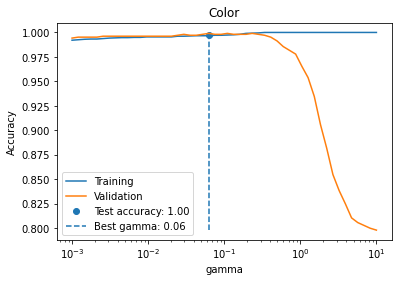

0.0625055192527397

In [18]:
gamma_values = np.logspace(-3, 1, 50)

tune_gaussian_svm_gamma('Color', gamma_values, C_color, y_color_train, y_color_validation, y_color_test)

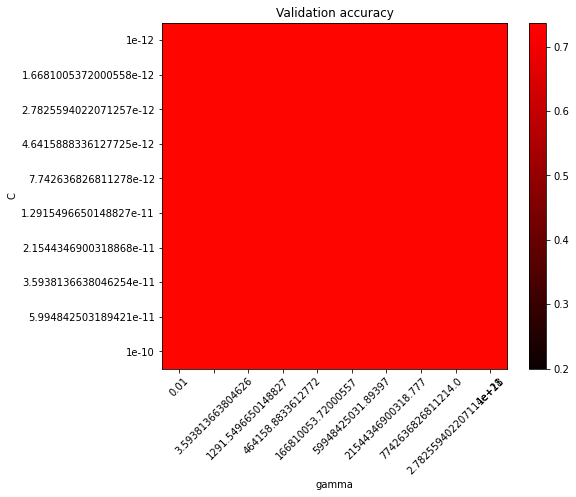

In [19]:
# SVM colormap
from matplotlib.colors import Normalize
from matplotlib import cm


# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):
    vmin: float
    vmax: float
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


gamma_values = np.logspace(-2, 21, 10)
c_values = np.logspace(-12, -10, 10)

scores = np.zeros((len(gamma_values), len(c_values)))
# for i, gamma in enumerate(gamma_values):
#     for j, C in enumerate(c_values):
#         clf = SVC(C=C, kernel='rbf', gamma=gamma)
#         clf.fit(X_train, y_color_train)
#         scores[i][j] = metrics.accuracy_score(y_color_validation, clf.predict(X_validation))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)

plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_values)), gamma_values, rotation=45)
plt.yticks(np.arange(len(c_values)), c_values)
plt.title("Validation accuracy")
plt.show()

In [24]:
# neural network

from sklearn.neural_network import MLPClassifier

def tune_neural_network_n_layers(name, layer_nums, y_train, y_validation, y_test, **kwargs):
    """
    Analyze different regularization values for support vector machine
    """
    training_accuracies = []
    validation_accuracies = []
    test_accuracies = []
    lalpha = len(layer_nums)
    for i, n in enumerate(layer_nums):
        print(f'\r[{"#" * round(80 * i/lalpha):{80}}] {round(100 * i/lalpha):3d}%', end='')
        regr = MLPClassifier(hidden_layer_sizes=np.repeat(30, n), **kwargs)
        regr.fit(X_train, y_train)
        train_pred = regr.predict(X_train)
        training_accuracies.append(metrics.accuracy_score(y_train, train_pred))
        validation_pred = regr.predict(X_validation)
        validation_accuracies.append(metrics.accuracy_score(y_validation, validation_pred))
        test_pred = regr.predict(X_test)
        test_accuracies.append(metrics.accuracy_score(y_test, test_pred))

    # plt.gca().set_xscale('log')

    plt.plot(layer_nums, training_accuracies, label='Training')
    plt.plot(layer_nums, validation_accuracies, label='Validation')
    plt.xlabel('number of layers')
    plt.ylabel('Accuracy')

    C = layer_nums[np.argmax(validation_accuracies)]
    plt.scatter(C, test_accuracies[np.argmax(validation_accuracies)], label=f'Test accuracy: {test_accuracies[np.argmax(validation_accuracies)]:.2f}')
    plt.vlines(C, np.min(validation_accuracies + training_accuracies), np.max(validation_accuracies + training_accuracies), linestyles='dashed', label=f'Best C: {C:.2f}')
    plt.legend()
    plt.title(name)
    plt.show()
    return C

[                                                                                ]   0%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[#########                                                                       ]  11%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[##################                                                              ]  22%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[###########################                                                     ]  33%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[####################################                                            ]  44%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[############################################                                    ]  56%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[#######################################################################         ]  89%

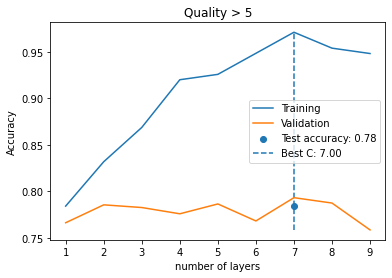

In [30]:
layer_nums = np.arange(1, 10)

size = tune_neural_network_n_layers('Quality > 5', layer_nums, y_quality_train, y_quality_validation, y_quality_test)

In [28]:

def tune_neural_network_layer_size(name, layer_sizes, layer_num, y_train, y_validation, y_test, **kwargs):
    """
    Analyze different regularization values for support vector machine
    """
    training_accuracies = []
    validation_accuracies = []
    test_accuracies = []
    lalpha = len(layer_sizes)
    for i, n in enumerate(layer_sizes):
        print(f'\r[{"#" * round(80 * i/lalpha):{80}}] {round(100 * i/lalpha):3d}%', end='')
        regr = MLPClassifier(hidden_layer_sizes=np.repeat(n, layer_num), **kwargs)
        regr.fit(X_train, y_train)
        train_pred = regr.predict(X_train)
        training_accuracies.append(metrics.accuracy_score(y_train, train_pred))
        validation_pred = regr.predict(X_validation)
        validation_accuracies.append(metrics.accuracy_score(y_validation, validation_pred))
        test_pred = regr.predict(X_test)
        test_accuracies.append(metrics.accuracy_score(y_test, test_pred))

    # plt.gca().set_xscale('log')

    plt.plot(layer_sizes, training_accuracies, label='Training')
    plt.plot(layer_sizes, validation_accuracies, label='Validation')
    plt.xlabel('layer size')
    plt.ylabel('Accuracy')

    size = layer_sizes[np.argmax(validation_accuracies)]
    plt.scatter(size, test_accuracies[np.argmax(validation_accuracies)], label=f'Test accuracy: {test_accuracies[np.argmax(validation_accuracies)]:.2f}')
    plt.vlines(size, np.min(validation_accuracies + training_accuracies), np.max(validation_accuracies + training_accuracies),
            linestyles='dashed', label=f'Best size: {size:.2f}')
    plt.legend()
    plt.title(name)
    plt.show()
    return size


[########                                                                        ]  10%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[################                                                                ]  20%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[########################                                                        ]  30%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[################################                                                ]  40%

/home/paulm/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[########################################################################        ]  90%

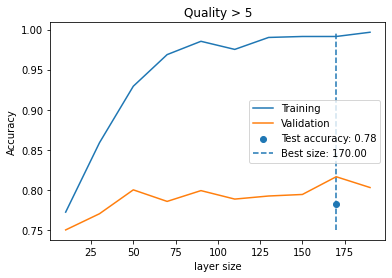

170

In [41]:
layer_sizes = np.arange(10, 200, 20)

tune_neural_network_layer_size('Quality > 5', layer_sizes, 2, y_quality_train, y_quality_validation, y_quality_test, max_iter=500)

1

alpha_values = np.linspace(0.00001, 10, 10)